In [1]:
%config InlineBackend.figure_format = 'retina'
import loompy
from loompy.color import zviridis
import scipy.sparse as sparse
import logging
import numpy as np
import matplotlib.pyplot as plt
import cytograph as cg
from tqdm import trange
_ = np.seterr(invalid='ignore')  # Ignore np.sqrt() warnings for zeros in long vectors
logging.getLogger().setLevel(logging.DEBUG)

2018-09-12 11:06:34,401 INFO: ERROR: failed to import igraph; some clustering methods will not work
2018-09-12 11:06:37,430 DEBUG: backend module://ipykernel.pylab.backend_inline version unknown


In [45]:
from binascii import hexlify
import os
key = hexlify(os.urandom(40))
key.decode()

'585c243930afc20aae25d305584ab9d0acc202d8164017422a61ac01841cad466b3b033f3423f4c1'

2018-09-12 11:06:37,556 DEBUG: findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/Users/stelin/anaconda/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


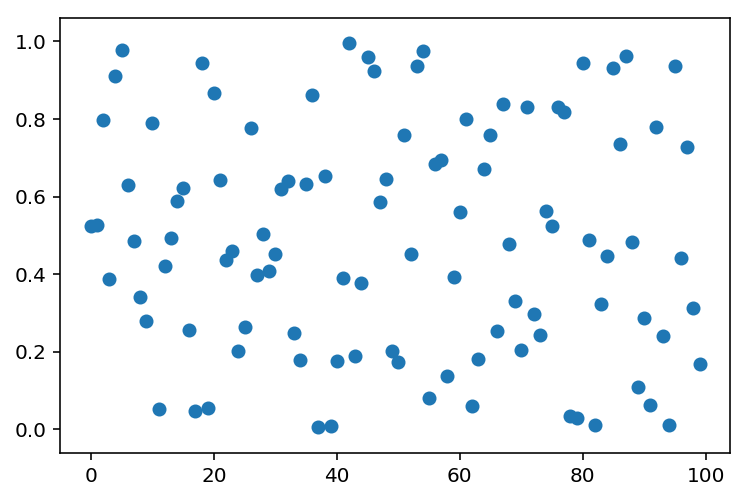

In [2]:
plt.scatter(x=np.arange(100),y=np.random.uniform(size=100))

In [3]:
from scvi.dataset import LoomDataset, CsvDataset, Dataset10X, AnnDataset
from scvi.dataset import BrainLargeDataset, CortexDataset, PbmcDataset, RetinaDataset, HematoDataset, CbmcDataset, BrainSmallDataset
from scvi.models import *
from scvi.inference import UnsupervisedTrainer

config = {
    "save_path": "/Users/stelin/build_20171205/"
}
n_epochs_all = config['n_epochs'] if 'n_epochs' in config else None
save_path = config['save_path'] if 'save_path' in config else 'data/'
n_samples_tsne = config['n_samples_tsne'] if 'n_samples_tsne' in config else None
n_samples_posterior_density = config['n_samples_posterior_density'] if 'n_samples_posterior_density' in config else None
train_size = config['train_size'] if 'train_size' in config else None
M_sampling_all = config['M_sampling'] if 'M_sampling' in config else None
M_permutation_all = config['M_permutation'] if 'M_permutation' in config else None
rate = config['rate'] if 'rate' in config else None

2018-09-12 11:06:41,765 DEBUG: backend agg version v2.2


In [8]:
f = "L1_Sympathetic_nfactors=100_k=20_ksmoothing=10_a=1_b=10_c=1_d=10_log=True_normalize=True_accel=False.loom"
#f = "/Users/stelin/build_20171205/L1_Hippocampus.loom"
with loompy.connect(save_path + f) as ds:
    ds.ca.ClusterID = ds.ca.Clusters
    normalizer = cg.Normalizer(False)
    normalizer.fit(ds)
    selected = cg.FeatureSelection(1000).fit(ds, mu=normalizer.mu, sd=normalizer.sd)
    genes = ds.ra.Gene[selected]

dataset = LoomDataset(f, save_path=save_path)
dataset.subsample_genes(subset_genes=selected)

File /Users/stelin/build_20171205/L1_Sympathetic_nfactors=100_k=20_ksmoothing=10_a=1_b=10_c=1_d=10_log=True_normalize=True_accel=False.loom already downloaded
Preprocessing dataset
Finished preprocessing dataset
Downsampling from 27998 to 1000 genes
Downsampling from 1490 to 1490 cells


In [9]:
n_epochs=100 if n_epochs_all is None else n_epochs_all
lr=1e-3
use_batches=False
use_cuda=False

vae = VAE(dataset.nb_genes, n_batch=dataset.n_batches * use_batches)
trainer = UnsupervisedTrainer(vae,
                              dataset,
                              train_size=0.75,
                              use_cuda=use_cuda,
                              frequency=5)
trainer.train(n_epochs=n_epochs, lr=lr)

training: 100%|██████████| 100/100 [00:45<00:00,  2.18it/s]


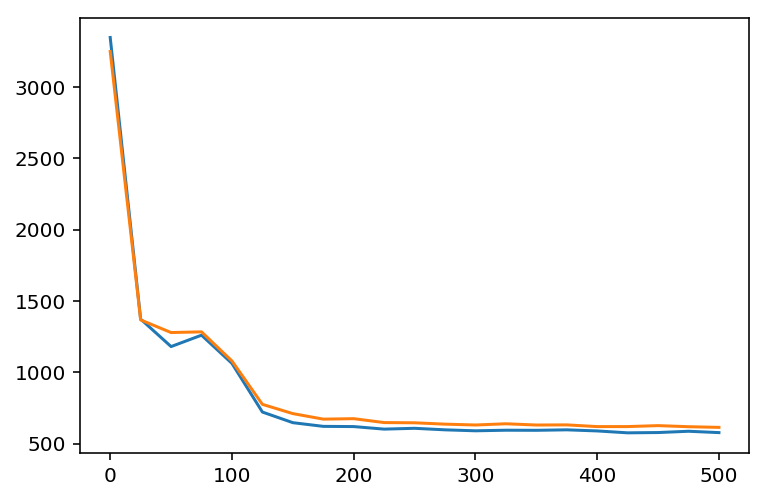

In [10]:
ll_train_set = trainer.history["ll_train_set"]
ll_test_set = trainer.history["ll_test_set"]
x = np.linspace(0,500,(len(ll_train_set)))
plt.plot(x, ll_train_set)
plt.plot(x, ll_test_set)
#plt.ylim(1150,1600)

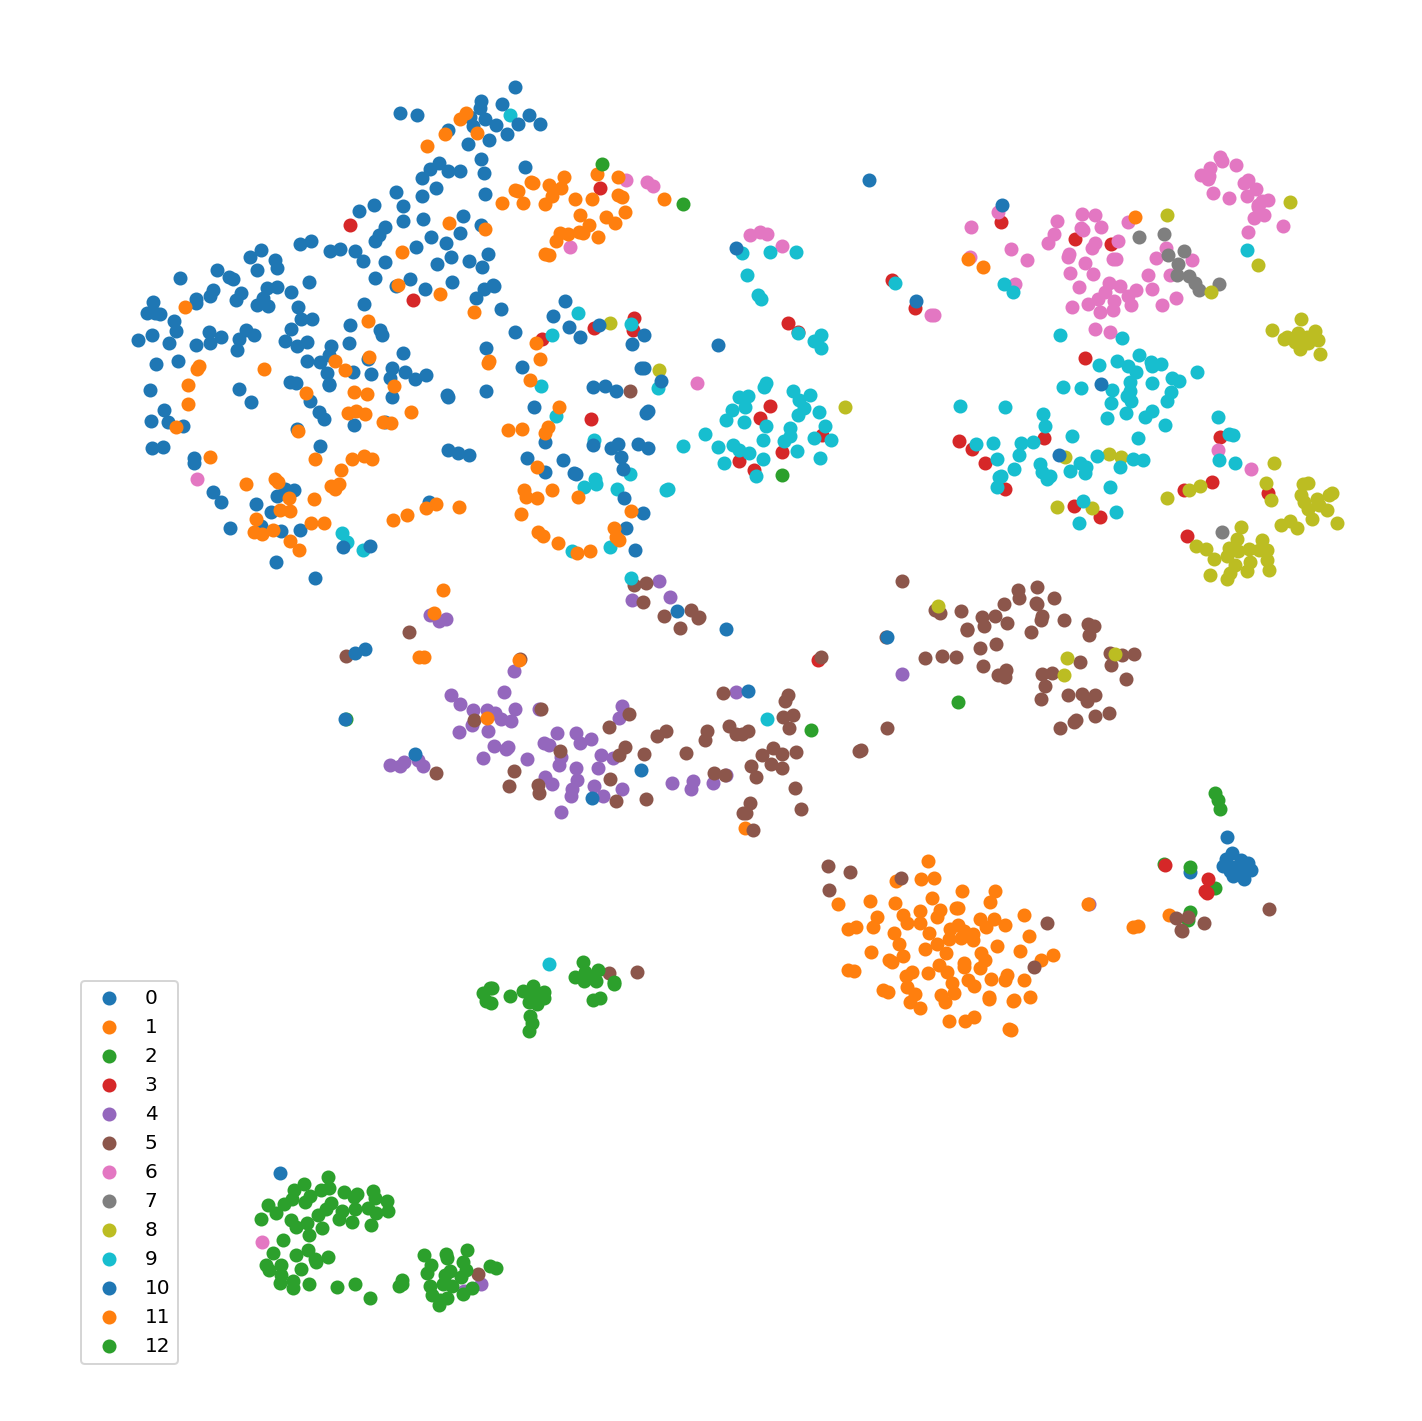

In [11]:
trainer.train_set.show_t_sne(n_samples=n_samples_tsne, color_by='labels')

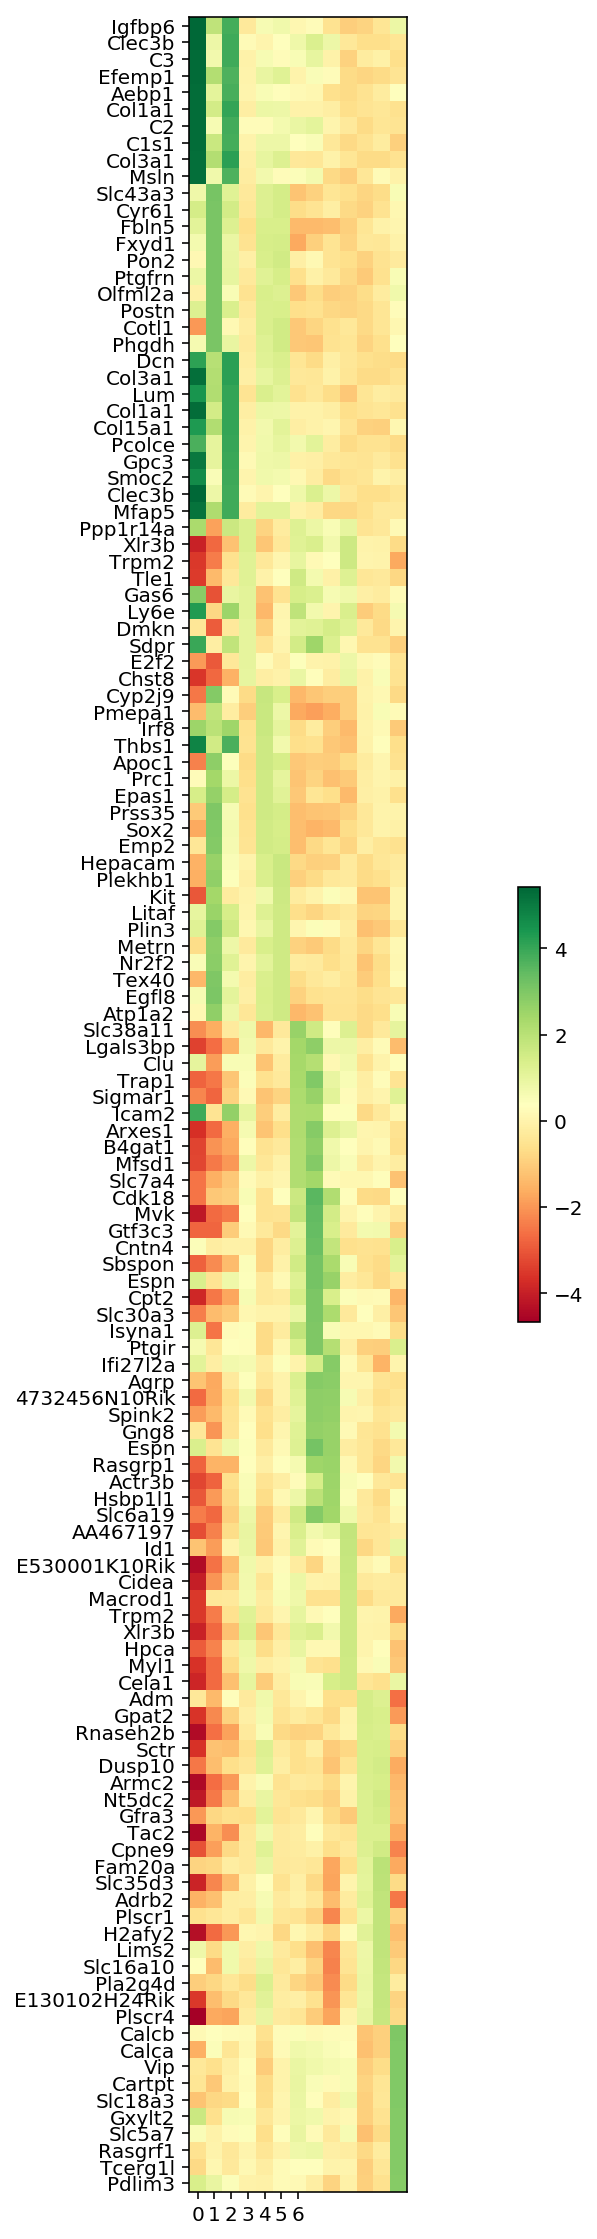

In [26]:
#genes, expression = trainer.train_set.differential_expression_table(M_sampling=100)

plt.figure(figsize=(20, 20))
im = plt.imshow(expression, cmap='RdYlGn', interpolation='none', aspect='equal')
ax = plt.gca()
ax.set_xticks(np.arange(0, 7, 1))
ax.set_yticklabels(genes)
ax.set_yticks(np.arange(0, len(genes), 1))
ax.tick_params(labelsize=10)
plt.colorbar(shrink=0.2)